# Solving Ordinary Differential Equations using PINNs

Now that we have familirized ourself with the Modulus APIs and solved the 1-dimensional diffusion equation in a single simulation and parameterized setting, we move to the next application of PINNs. In this notebook we will solve the system of differential equations that define a coupled spring mass problem. In this tutorial we will see how to solve the transient problems over small time intervals easily by treating time as a continuous variable. We will also use PINNs to solve the problem in an inverse setting where we have the solution data and we use PINN to find the coefficient of the ODE.

You can refer to the [Modulus User Documentation](https://docs.nvidia.com/deeplearning/modulus/index.html#) for more examples on solving different types of time domain problems and inverse problems. 

### Learning Outcomes
1. How to use Modulus to simulate transient problems using PINNs by treating time as a continuous variable
2. How to use Modulus to solve a inverse problem
    

## Problem Description

In this tutorial, we will solve a simple spring mass system as shown in figure below. The systems shows three masses attached to each other by four springs. The springs slide along a friction-less horizontal surface. The masses are assumed to be point masses and the springs are mass-less.

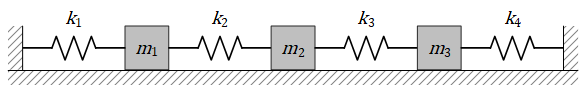

The model's equations are given as below:
$$
\begin{equation}\label{ode_eqn}
\begin{split}
m_1 x_1''(t) &= -k_1 x_1(t) + k_2(x_2(t) - x_1(t)),\\
m_2 x_2''(t) &= -k_2 (x_2(t) - x_1(t))+ k_3(x_3(t) - x_2(t)),\\
m_3 x_3''(t) &= -k_3 (x_3(t) - x_2(t)) - k_4 x_3(t). \end{split}
\end{equation}
$$

Where, $x_1(t), x_2(t), \text{and } x_3(t)$ denote the mass positions along the horizontal surface measured from their equilibrium position, positive right and negative left. As shown in the figure, first and the last spring are fixed to the walls. 

For the first part of the tutorial, we will assume the following conditions:
$$
\begin{equation}\label{ode_IC}
\begin{split}
[m_1, m_2, m_3] &= [1, 1, 1],\\
[k_1, k_2, k_3, k_4] &= [2, 1, 1, 2],\\
[x_1(0), x_2(0), x_3(0)] &= [1, 0, 0],\\
[x_1'(0), x_2'(0), x_3'(0)] &= [0, 0, 0].
\end{split}
\end{equation}
$$

## Case Setup

Now that we have our problem defined, let's take a look at the code required to solve it using Modulus. 

### Note

Now we will describe the contents of the [`spring_mass_solver.py`](../../source_code/spring_mass/spring_mass_solver.py) script 

## Defining the differential equations for the problem

This process is similar to the previous tutorial. We will write each parameter ($k's \text{ and } m's$) as function and substitute it as a number if its constant. This will allow us to parameterize any of this constants by passing them as a string. This will also allow us to solve the inverse problem where either of these quantitity is unknown and can be predicted by the neural network. The PDE is defined in [`spring_mass_ode.py`](../../source_code/spring_mass/spring_mass_ode.py) script 

```python
from sympy import Symbol, Function, Number
from modulus.eq.pde import PDE


class SpringMass(PDES):
    name = "SpringMass"

    def __init__(self, k=(2, 1, 1, 2), m=(1, 1, 1)):

        self.k = k
        self.m = m

        k1 = k[0]
        k2 = k[1]
        k3 = k[2]
        k4 = k[3]
        m1 = m[0]
        m2 = m[1]
        m3 = m[2]

        t = Symbol("t")
        input_variables = {"t": t}

        x1 = Function("x1")(*input_variables)
        x2 = Function("x2")(*input_variables)
        x3 = Function("x3")(*input_variables)

        if type(k1) is str:
            k1 = Function(k1)(*input_variables)
        elif type(k1) in [float, int]:
            k1 = Number(k1)
        if type(k2) is str:
            k2 = Function(k2)(*input_variables)
        elif type(k2) in [float, int]:
            k2 = Number(k2)
        if type(k3) is str:
            k3 = Function(k3)(*input_variables)
        elif type(k3) in [float, int]:
            k3 = Number(k3)
        if type(k4) is str:
            k4 = Function(k4)(*input_variables)
        elif type(k4) in [float, int]:
            k4 = Number(k4)

        if type(m1) is str:
            m1 = Function(m1)(*input_variables)
        elif type(m1) in [float, int]:
            m1 = Number(m1)
        if type(m2) is str:
            m2 = Function(m2)(*input_variables)
        elif type(m2) in [float, int]:
            m2 = Number(m2)
        if type(m3) is str:
            m3 = Function(m3)(*input_variables)
        elif type(m3) in [float, int]:
            m3 = Number(m3)

        self.equations = {}
        self.equations["ode_x1"] = m1 * (x1.diff(t)).diff(t) + k1 * x1 - k2 * (x2 - x1)
        self.equations["ode_x2"] = (
            m2 * (x2.diff(t)).diff(t) + k2 * (x2 - x1) - k3 * (x3 - x2)
        )
        self.equations["ode_x3"] = m3 * (x3.diff(t)).diff(t) + k3 * (x3 - x2) + k4 * x3
```

## Solving the ODEs: Defining the Neural Network nodes, Creating Geometry and defining constraints (ICs, BCs, PDEs)

Once we have the ODEs defined, we can easily form the constraints needed for optimization as seen in earlier tutorials. This example, uses `Point1D` geometry to create the point mass. We will also have to define the time range of the solution and create symbol for time ($t$) to define the initial condition, etc. in the domain. The below code shows the geometry definition for this problem. Note that this tutorial does not use the x-coordinate ($x$) information of the point, it is only used to sample a point in space. The point is assigned different values for variable $t$ only (initial conditions and ODEs over the time-range). The code to generate the nodes and relevant constraints is shown below.

```python
import numpy as np
from sympy import Symbol, Eq

import modulus
from modulus.hydra import ModulusConfig, instantiate_arch
from modulus.solver import Solver
from modulus.domain import Domain
from modulus.geometry.primitives_1d import Point1D
from modulus.geometry import Parameterization
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseBoundaryConstraint,
)

from spring_mass_ode import SpringMass


@modulus.main(config_path="conf", config_name="config")
def run(cfg: ModulusConfig) -> None:
    # make list of nodes to unroll graph on
    sm = SpringMass(k=(2, 1, 1, 2), m=(1, 1, 1))
    sm_net = instantiate_arch(
        input_keys=[Key("t")],
        output_keys=[Key("x1"), Key("x2"), Key("x3")],
        cfg=cfg.arch.fully_connected,
    )
    nodes = sm.make_nodes() + [
        sm_net.make_node(name="spring_mass_network", jit=cfg.jit)
    ]

    # add constraints to solver
    # make geometry
    geo = Point1D(0)
    t_max = 10.0
    t_symbol = Symbol("t")
    x = Symbol("x")
    time_range = {t_symbol: (0, t_max)}

    # make domain
    domain = Domain()

    # initial conditions
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": 1.0, "x2": 0, "x3": 0, "x1__t": 0, "x2__t": 0, "x3__t": 0},
        batch_size=cfg.batch_size.IC,
        lambda_weighting={
            "x1": 1.0,
            "x2": 1.0,
            "x3": 1.0,
            "x1__t": 1.0,
            "x2__t": 1.0,
            "x3__t": 1.0,
        },
        parameterization=Parameterization({t_symbol: 0}),
    )
    domain.add_constraint(IC, name="IC")

    # solve over given time period
    interior = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"ode_x1": 0.0, "ode_x2": 0.0, "ode_x3": 0.0},
        batch_size=cfg.batch_size.interior,
        parameterization=Parameterization(time_range),
    )
    domain.add_constraint(interior, "interior")
```

## Adding Validation data

Next we will define the validation data for this problem. The solution of this problem can be obtained analytically and the expression can be coded into dictionaries of numpy arrays for `x1`, `x2`, and `x3`. This part of the code is similar to the previous diffusion example.

```python
    # add validation data
    deltaT = 0.001
    t = np.arange(0, t_max, deltaT)
    t = np.expand_dims(t, axis=-1)
    invar_numpy = {"t": t}
    outvar_numpy = {
        "x1": (1 / 6) * np.cos(t)
        + (1 / 2) * np.cos(np.sqrt(3) * t)
        + (1 / 3) * np.cos(2 * t),
        "x2": (2 / 6) * np.cos(t)
        + (0 / 2) * np.cos(np.sqrt(3) * t)
        - (1 / 3) * np.cos(2 * t),
        "x3": (1 / 6) * np.cos(t)
        - (1 / 2) * np.cos(np.sqrt(3) * t)
        + (1 / 3) * np.cos(2 * t),
    }
    validator = PointwiseValidator(
        nodes=nodes, invar=invar_numpy, true_outvar=outvar_numpy, batch_size=1024
    )
    domain.add_validator(validator)
```

## Solver and training 

Now that we have the definitions for the various constraints and domains complete, we can form the solver and run the problem. The code to do the same can be found below.

```python
    # make solver
    slv = Solver(cfg, domain)

    # start solver
    slv.solve()


if __name__ == "__main__":
    run()
```

Awesome! We have just completed the file set up for the problem. We are now ready to solve the sytem of ODEs using Neural Networks!

In [ ]:
import os
os.environ["RANK"]="0"
os.environ["WORLD_SIZE"]="1"
os.environ["MASTER_ADDR"]="localhost"

In [ ]:
!python3 ../../source_code/spring_mass/spring_mass_solver.py

## Visualizing the solution

The .npz arrays can be plotted to visualize the output of the simulation. The .npz files that are created are found in the `outputs/` directory. The below figure shows the comparison of the neural network solution and the analytical solution. Again, we have a very good agreement in both the results. 

<img src="comparison.png" alt="Drawing" style="width: 500px;"/>

The below script shows an example of how the npz arrays can be plotted. 

In [ ]:
%%capture
import sys
!{sys.executable} -m pip install ipympl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

base_dir = "outputs/spring_mass_solver/validators/"

# plot in 1d
data = np.load(base_dir + "validator.npz", allow_pickle=True)
data = np.atleast_1d(data.f.arr_0)[0]

plt.plot(data["t"], data["true_x1"], label="True x1")
plt.plot(data["t"], data["true_x2"], label="True x2")
plt.plot(data["t"], data["true_x3"], label="True x3")
plt.plot(data["t"], data["pred_x1"], label="Pred x1")
plt.plot(data["t"], data["pred_x2"], label="Pred x2")
plt.plot(data["t"], data["pred_x3"], label="Pred x3")
plt.legend()
plt.savefig('comparison_spring_mass.png')

# Solving the Inverse Problem

Another important advantage of a neural network solver over traditional numerical methods is its ability to solve inverse problems. In an inverse problem, we start with a set of observations and then use those observations to calculate the causal factors that produced them. To demonstrate this concept we will solve the same spring mass system in an inverse setting. Specifically, we will assume that the data for the displacements of the 3 masses $x_1, x_2 \text{ and } x_3$ is available to us through analytical solution and the first mass ($m_1$) and the last spring coefficient ($k_4$) is unknown. We will use the neural network to assimilate the displacements from the analytical solution and use it to invert out the unknown quantites from ODEs.

## Case Setup

The equation file again remains same for this part. Here, we will use the `PointwiseConstraint` class to assimilate the solution in the training data. We will make a network to memorize the three displacements by developing a mapping between $t$ and $(x_1, x_2, x_3)$. The second network will be trained to invert out the desired quantites viz. $(m_1, k_4)$. 

### Note

Now we will describe the contents of the [`spring_mass_inverse.py`](../../source_code/spring_mass/spring_mass_inverse.py) script 

## Defining the equations, Networks and Nodes for an Inverse problem

Since part of the problem involves memorizing the given solution, we will have `'t'` as input numpy array and `'x_1', 'x_2', 'x_3', 'ode_x1', 'ode_x2', 'ode_x3'` as the output numpy arrays. Setting `'x_1', 'x_2', 'x_3'` as input values from analytical data, we are essentially making the network assimilate the analytical distribution of these variables in the selected domain. Setting `'ode_x1', 'ode_x2', 'ode_x3'` equal to 0, we will also inform the network to satisfy the ODE losses at those sampled points. Now, assuming that we also know the initial conditions of the solution, except the `'m_1'` and `'k_4'`, all the variables in these ODEs are known. Thus the network can use this information to invert out the unknowns. The below code shows the data preparation step. 

```python
import torch
import numpy as np
from sympy import Symbol, Eq

import modulus
from modulus.hydra import ModulusConfig, instantiate_arch
from modulus.solver import Solver
from modulus.domain import Domain
from modulus.geometry.primitives_1d import Point1D
from modulus.geometry import Parameterization
from modulus.domain.constraint import (
    PointwiseBoundaryConstraint,
    PointwiseConstraint,
)
from modulus.domain.validator import PointwiseValidator
from modulus.domain.monitor import PointwiseMonitor
from modulus.key import Key
from modulus.node import Node

from spring_mass_ode import SpringMass


@modulus.main(config_path="conf", config_name="config_inverse")
def run(cfg: ModulusConfig) -> None:
    # prepare data
    t_max = 10.0
    deltaT = 0.01
    t = np.arange(0, t_max, deltaT)
    t = np.expand_dims(t, axis=-1)

    invar_numpy = {"t": t}
    outvar_numpy = {
        "x1": (1 / 6) * np.cos(t)
        + (1 / 2) * np.cos(np.sqrt(3) * t)
        + (1 / 3) * np.cos(2 * t),
        "x2": (2 / 6) * np.cos(t)
        + (0 / 2) * np.cos(np.sqrt(3) * t)
        - (1 / 3) * np.cos(2 * t),
        "x3": (1 / 6) * np.cos(t)
        - (1 / 2) * np.cos(np.sqrt(3) * t)
        + (1 / 3) * np.cos(2 * t),
    }
    outvar_numpy.update({"ode_x1": np.full_like(invar_numpy["t"], 0)})
    outvar_numpy.update({"ode_x2": np.full_like(invar_numpy["t"], 0)})
    outvar_numpy.update({"ode_x3": np.full_like(invar_numpy["t"], 0)})
```

The process of creating neural networks for an inverse problem is similar to other problems we have seen in previous tutorials. However, as the information for the displacements, and in turn their gradients (i.e. velocities and accelerations), is already present (from analytical data) for the network to memorize, we will detach these variables in computation graph in their respective equations. This means that only the networks predicting `'m1'` and `'k4'` will be optimized to minimize the equation residuals. The displacements, velocities and accelerations are treated as ground truth data.

Also, note that the the mass and spring constant are passed in as Symbolic variables (`'m1'` and `'k4'` respectively) to the
equations as they are unknowns in this problem.

```python
    # make list of nodes to unroll graph on
    sm = SpringMass(k=(2, 1, 1, "k4"), m=("m1", 1, 1))
    sm_net = instantiate_arch(
        input_keys=[Key("t")],
        output_keys=[Key("x1"), Key("x2"), Key("x3")],
        cfg=cfg.arch.fully_connected,
    )
    invert_net = instantiate_arch(
        input_keys=[Key("t")],
        output_keys=[Key("m1"), Key("k4")],
        cfg=cfg.arch.fully_connected,
    )

    nodes = (
        sm.make_nodes(
            detach_names=[
                "x1",
                "x1__t",
                "x1__t__t",
                "x2",
                "x2__t",
                "x2__t__t",
                "x3",
                "x3__t",
                "x3__t__t",
            ]
        )
        + [sm_net.make_node(name="spring_mass_network", jit=cfg.jit)]
        + [invert_net.make_node(name="invert_network", jit=cfg.jit)]
    )

```

For this problem, we will use the solution coming from analytical solution in from of numpy arrays we defined earlier. We will use the `PointwiseConstraint` class to handle such input data. The `PointwiseConstraint` class takes in separate dictionaries for input variables and output variables. These dictionaries have a key for each variable and a numpy array of values associated to the key. The below code shows the addition of the boundary constraint and the constraint coming from the numpy arrays we just defined.

```python
       # add constraints to solver
    # make geometry
    geo = Point1D(0)
    t_symbol = Symbol("t")
    x = Symbol("x")
    time_range = {t_symbol: (0, t_max)}

    # make domain
    domain = Domain()

    # initial conditions
    IC = PointwiseBoundaryConstraint(
        nodes=nodes,
        geometry=geo,
        outvar={"x1": 1.0, "x2": 0, "x3": 0, "x1__t": 0, "x2__t": 0, "x3__t": 0},
        batch_size=cfg.batch_size.IC,
        lambda_weighting={
            "x1": 1.0,
            "x2": 1.0,
            "x3": 1.0,
            "x1__t": 1.0,
            "x2__t": 1.0,
            "x3__t": 1.0,
        },
        parameterization=Parameterization({t_symbol: 0}),
    )
    domain.add_constraint(IC, name="IC")

    # data and pdes
    data = PointwiseConstraint.from_numpy(
        nodes=nodes,
        invar=invar_numpy,
        outvar=outvar_numpy,
        batch_size=cfg.batch_size.data,
    )
    domain.add_constraint(data, name="Data")
```

## Adding monitors

For this tutorial, we will monitor the convergence of average `'m_1'` and `'k_4'` inside the domain as the solution progresses. Once we find that the average value of these quantities have reached a steady value, we can end the simulation. The code to generate such monitors can be found below

```python
    # add monitors
    monitor = PointwiseMonitor(
        invar_numpy,
        output_names=["m1"],
        metrics={"mean_m1": lambda var: torch.mean(var["m1"])},
        nodes=nodes,
    )
    domain.add_monitor(monitor)

    monitor = PointwiseMonitor(
        invar_numpy,
        output_names=["k4"],
        metrics={"mean_k4": lambda var: torch.mean(var["k4"])},
        nodes=nodes,
    )
    domain.add_monitor(monitor)
```

## Solver and training

Now that we have the definitions for the various constraints and domains complete, we can form the solver and run the problem similar to before. The code to do the same can be found below.

```python
    # make solver
    slv = Solver(cfg, domain)

    # start solver
    slv.solve()


if __name__ == "__main__":
    run()
```

In [ ]:
!python3 ../../source_code/spring_mass/spring_mass_inverse.py

## Visualizing the solution

We can monitor the Tensorboard plots to see the convergence of the simulation and the final values of the $m_1$ and $k_4$. We see that after sufficient training, we get the $m_1$ and $k_4$ as 1 and 2 respectively. These were the same values that we used to create the analytical solution.

# Licensing
This material is released by OpenACC-Standard.org, in collaboration with NVIDIA Corporation, under the Creative Commons Attribution 4.0 International (CC BY 4.0).
